Training Accuracy: 1.0
Validation Accuracy: 0.8875
Training ROC AUC: 1.0
Validation ROC AUC: 0.9186991869918699

Confusion Matrix (Validation):
 [[114   9]
 [  9  28]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93       123
           1       0.76      0.76      0.76        37

    accuracy                           0.89       160
   macro avg       0.84      0.84      0.84       160
weighted avg       0.89      0.89      0.89       160


Best Threshold: 0.49 with F1 Score: 0.8875

Cross-validation Accuracy Scores: [0.85    0.88125 0.8875  0.85    0.8625 ]
Mean CV Accuracy: 0.86625


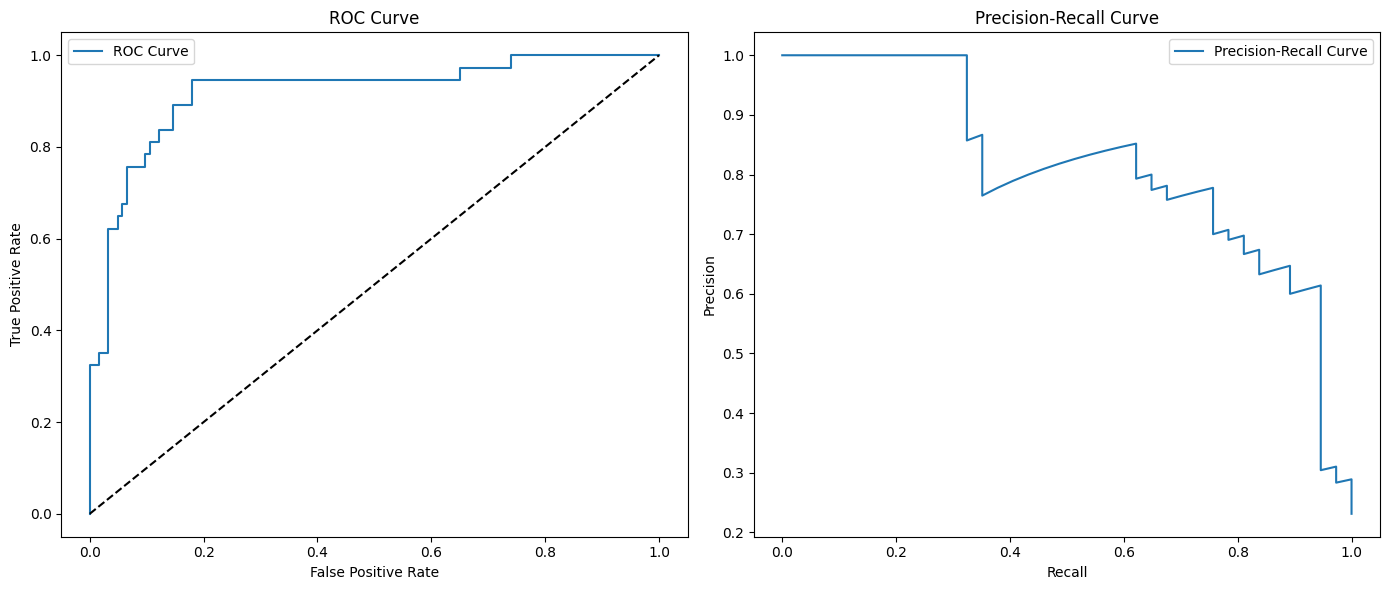

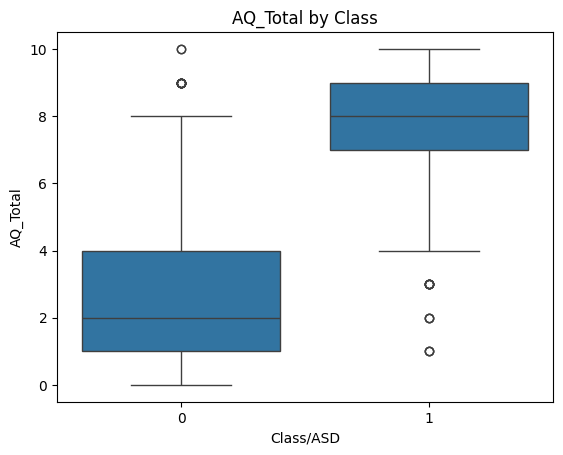

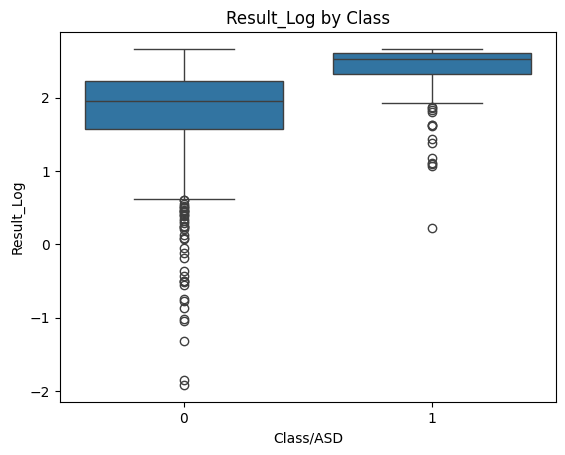

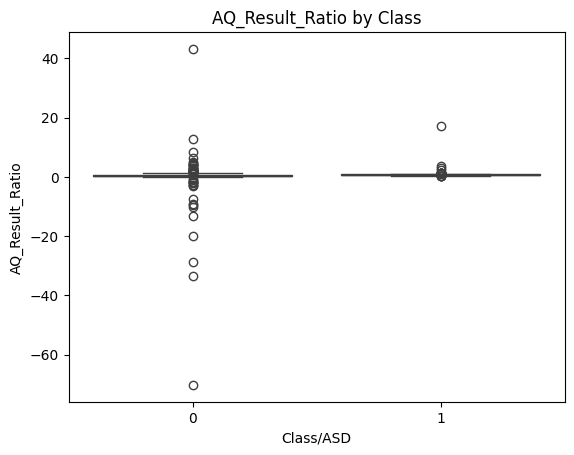


Test predictions saved to rf_submission.csv


In [2]:
# ===============================
#         IMPORTS
# ===============================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                             roc_auc_score, roc_curve, precision_recall_curve)
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# ===============================
#         LOAD DATA
# ===============================
train_data = pd.read_csv('Autism-prediction/train (1).csv')
test_data = pd.read_csv('Autism-prediction/test.csv')

# ===============================
#      BASIC CLEANING
# ===============================
for col in ['ethnicity', 'contry_of_res', 'relation']:
    train_data[col] = train_data[col].fillna('Unknown').replace('?', 'Unknown')
    test_data[col] = test_data[col].fillna('Unknown').replace('?', 'Unknown')

# Remove unused columns
excluded_cols = ['ID', 'Class/ASD', 'ethnicity', 'jaundice', 'austim', 
                 'contry_of_res', 'used_app_before', 'age_desc', 'relation', 'gender']
target_col = 'Class/ASD'

# ===============================
#  FEATURE ENGINEERING (SIMPLE)
# ===============================
aq_cols = [f'A{i}_Score' for i in range(1, 11)]
train_data['AQ_Total'] = train_data[aq_cols].sum(axis=1)
test_data['AQ_Total'] = test_data[aq_cols].sum(axis=1)

train_data['Result_Log'] = np.log1p(train_data['result'])
test_data['Result_Log'] = np.log1p(test_data['result'])
train_data['AQ_Result_Ratio'] = train_data['AQ_Total'] / (train_data['result'] + 0.1)
test_data['AQ_Result_Ratio'] = test_data['AQ_Total'] / (test_data['result'] + 0.1)
train_data['Family_Autism'] = (train_data['austim'] == 'yes').astype(int)
test_data['Family_Autism'] = (test_data['austim'] == 'yes').astype(int)
train_data['Had_Jaundice'] = (train_data['jaundice'] == 'yes').astype(int)
test_data['Had_Jaundice'] = (test_data['jaundice'] == 'yes').astype(int)

# ===============================
#  LABEL ENCODING (Train & Test)
# ===============================
cat_cols = ['relation', 'ethnicity', 'contry_of_res', 'gender']
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    combined = pd.concat([train_data[col], test_data[col]], axis=0).astype(str)
    le.fit(combined)
    train_data[col] = le.transform(train_data[col].astype(str))
    test_data[col] = le.transform(test_data[col].astype(str))
    le_dict[col] = le

# ===============================
#      FINAL FEATURE SETUP
# ===============================
features = [col for col in train_data.columns if col not in excluded_cols]
X = train_data[features]
y = train_data[target_col]
X_test = test_data[features]

# ===============================
#     SPLIT + IMPUTE + SCALE
# ===============================
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

pipeline = ImbPipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('sampler', SMOTE(random_state=42)),
    ('scaler', RobustScaler()),
    ('clf', RandomForestClassifier(n_estimators=1000, max_depth=12, random_state=42, class_weight='balanced'))
])

pipeline.fit(X_train, y_train)

# ===============================
#         EVALUATION
# ===============================
y_train_pred = pipeline.predict(X_train)
y_valid_pred = pipeline.predict(X_valid)
y_valid_prob = pipeline.predict_proba(X_valid)[:, 1]
y_train_prob = pipeline.predict_proba(X_train)[:, 1]

print("Training Accuracy:", accuracy_score(y_train, y_train_pred))
print("Validation Accuracy:", accuracy_score(y_valid, y_valid_pred))
print("Training ROC AUC:", roc_auc_score(y_train, y_train_prob))
print("Validation ROC AUC:", roc_auc_score(y_valid, y_valid_prob))
print("\nConfusion Matrix (Validation):\n", confusion_matrix(y_valid, y_valid_pred))
print("\nClassification Report:\n", classification_report(y_valid, y_valid_pred))

# ===============================
#  PROBABILITY THRESHOLD TUNING
# ===============================
thresholds = np.linspace(0, 1, 101)
best_f1 = 0
best_thresh = 0.5
for t in thresholds:
    preds = (y_valid_prob >= t).astype(int)
    f1 = classification_report(y_valid, preds, output_dict=True)['weighted avg']['f1-score']
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

print(f"\nBest Threshold: {best_thresh:.2f} with F1 Score: {best_f1:.4f}")

# ===============================
#       CROSS-VALIDATION
# ===============================
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y, cv=skf, scoring='accuracy')
print("\nCross-validation Accuracy Scores:", scores)
print("Mean CV Accuracy:", scores.mean())

# ===============================
#     CALIBRATION CURVE + ROC
# ===============================
fpr, tpr, _ = roc_curve(y_valid, y_valid_prob)
prec, rec, _ = precision_recall_curve(y_valid, y_valid_prob)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rec, prec, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.tight_layout()
plt.show()

# ===============================
#         BOX PLOTS
# ===============================
important_feats = ['AQ_Total', 'Result_Log', 'AQ_Result_Ratio']
for feat in important_feats:
    sns.boxplot(data=train_data, x='Class/ASD', y=feat)
    plt.title(f'{feat} by Class')
    plt.show()

# ===============================
#        TEST PREDICTIONS
# ===============================
test_pred_prob = pipeline.predict_proba(X_test)[:, 1]
test_pred = (test_pred_prob >= best_thresh).astype(int)
submission = pd.DataFrame({
    'ID': test_data['ID'],
    'Class/ASD': test_pred
})
submission.to_csv('rf_submission.csv', index=False)
print("\nTest predictions saved to rf_submission.csv")


In [1]:
# ===============================
#         IMPORTS
# ===============================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                             roc_auc_score, roc_curve, precision_recall_curve, f1_score)
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTEENN
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

# ===============================
#         LOAD DATA
# ===============================
train_data = pd.read_csv('Autism-prediction/train (1).csv')
test_data = pd.read_csv('Autism-prediction/test.csv')

# ===============================
#      BASIC CLEANING
# ===============================
for col in ['ethnicity', 'contry_of_res', 'relation']:
    train_data[col] = train_data[col].fillna('Unknown').replace('?', 'Unknown')
    test_data[col] = test_data[col].fillna('Unknown').replace('?', 'Unknown')

# Remove unused columns
excluded_cols = ['ID', 'Class/ASD', 'ethnicity', 'jaundice', 'austim', 
                 'contry_of_res', 'used_app_before', 'age_desc', 'relation', 'gender']
target_col = 'Class/ASD'

# ===============================
#  FEATURE ENGINEERING (ENHANCED)
# ===============================
aq_cols = [f'A{i}_Score' for i in range(1, 11)]
train_data['AQ_Total'] = train_data[aq_cols].sum(axis=1)
test_data['AQ_Total'] = test_data[aq_cols].sum(axis=1)
train_data['AQ_Mean'] = train_data[aq_cols].mean(axis=1)
test_data['AQ_Mean'] = test_data[aq_cols].mean(axis=1)
train_data['AQ_Std'] = train_data[aq_cols].std(axis=1).fillna(0)
test_data['AQ_Std'] = test_data[aq_cols].std(axis=1).fillna(0)
train_data['Result_Log'] = np.log1p(train_data['result'])
test_data['Result_Log'] = np.log1p(test_data['result'])
train_data['AQ_Result_Ratio'] = train_data['AQ_Total'] / (train_data['result'] + 0.1)
test_data['AQ_Result_Ratio'] = test_data['AQ_Total'] / (test_data['result'] + 0.1)
train_data['Age_Sq'] = train_data['age'] ** 2
test_data['Age_Sq'] = test_data['age'] ** 2
train_data['Family_Autism'] = (train_data['austim'] == 'yes').astype(int)
test_data['Family_Autism'] = (test_data['austim'] == 'yes').astype(int)
train_data['Had_Jaundice'] = (train_data['jaundice'] == 'yes').astype(int)
test_data['Had_Jaundice'] = (test_data['jaundice'] == 'yes').astype(int)

# ===============================
#  LABEL ENCODING (Train & Test)
# ===============================
cat_cols = ['relation', 'ethnicity', 'contry_of_res', 'gender']
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    combined = pd.concat([train_data[col], test_data[col]], axis=0).astype(str)
    le.fit(combined)
    train_data[col] = le.transform(train_data[col].astype(str))
    test_data[col] = le.transform(test_data[col].astype(str))
    le_dict[col] = le

# ===============================
#      FINAL FEATURE SETUP
# ===============================
features = [col for col in train_data.columns if col not in excluded_cols]
X_all = train_data[features]
y_all = train_data[target_col]
X_final_test = test_data[features]

# ===============================
#  TRAIN-TEST SPLIT
# ===============================
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, stratify=y_all, random_state=42)

# ===============================
#  MODEL PIPELINE (Random Forest)
# ===============================
rf_model = ImbPipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('sampler', SMOTEENN(random_state=42)),
    ('scaler', RobustScaler()),
    ('rf', RandomForestClassifier(n_estimators=1000, max_depth=12, class_weight='balanced', random_state=42))
])

# ===============================
#   TRAIN, CV AND TEST EVAL
# ===============================
rf_model.fit(X_train, y_train)

# Training Eval
train_probs = rf_model.predict_proba(X_train)[:, 1]
train_preds = rf_model.predict(X_train)
train_acc = accuracy_score(y_train, train_preds)
train_auc = roc_auc_score(y_train, train_probs)

# Cross-Validation Eval
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_acc_scores = cross_val_score(rf_model, X_train, y_train, scoring='accuracy', cv=skf)
cv_auc_scores = cross_val_score(rf_model, X_train, y_train, scoring='roc_auc', cv=skf)

# Test Eval
y_prob = rf_model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * precision * recall / (precision + recall + 1e-10)
best_threshold = thresholds[np.argmax(f1_scores)]
y_pred = (y_prob >= best_threshold).astype(int)

# ===============================
#     METRIC OUTPUT
# ===============================
print("\n=== Training Scores ===")
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Train ROC AUC:  {train_auc:.4f}")

print("\n=== Cross-Validation Scores ===")
print(f"CV Accuracy: {cv_acc_scores.mean():.4f} ± {cv_acc_scores.std():.4f}")
print(f"CV ROC AUC:  {cv_auc_scores.mean():.4f} ± {cv_auc_scores.std():.4f}")

print("\n=== Final Evaluation (Test Set) ===")
print(f"Accuracy:      {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC AUC:       {roc_auc_score(y_test, y_prob):.4f}")
print(f"Best Threshold:{best_threshold:.4f}")
print(f"F1 Score:      {f1_score(y_test, y_pred):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))



=== Training Scores ===
Train Accuracy: 0.8828
Train ROC AUC:  0.9414

=== Cross-Validation Scores ===
CV Accuracy: 0.8391 ± 0.0213
CV ROC AUC:  0.8941 ± 0.0209

=== Final Evaluation (Test Set) ===
Accuracy:      0.9000
ROC AUC:       0.9144
Best Threshold:0.7460
F1 Score:      0.7838

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93       123
           1       0.78      0.78      0.78        37

    accuracy                           0.90       160
   macro avg       0.86      0.86      0.86       160
weighted avg       0.90      0.90      0.90       160

